In [40]:
import mysql.connector

# Connection details
host = 'localhost'
user = 'root'
password = ''
database = 'data_smartphone'
port = 3306

# Establish a connection to the database
connection = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    database=database,
    port=port
)

print("Koneksi ke database berhasil")


Koneksi ke database berhasil


In [42]:
import pandas as pd
from IPython.display import display

def execute_query_to_dataframe(connection, query):
    try:
        # Create a cursor object
        cursor = connection.cursor(dictionary=True)
        
        # Execute the SQL query
        cursor.execute(query)
        
        # Fetch all the results
        result = cursor.fetchall()
        
        # Convert the results to a Pandas DataFrame
        df = pd.DataFrame(result)
        
        return df
        
    except mysql.connector.Error as err:
        print(f"Error: {err}")
        return None
    finally:
        # Close the cursor but not the connection
        cursor.close()

# Define the SQL query for LEFT JOIN
query = """
SELECT 
    data.Merek,
    data.Tipe,
    data.Bulan,
    data.Jumlah_Stok,
    data.Jumlah_Terjual,
    data.Harga_Satuan_Rp,
    data.Total_Penjualan_Rp,
    data_spesifikasi.Kamera_Utama_MP,
    data_spesifikasi.Kamera_Depan_MP,
    data_spesifikasi.RAM,
    data_spesifikasi.Memori_Internal,
    data_spesifikasi.Baterai_mAh,
    data_spesifikasi.Jenis_Layar
FROM 
    data
LEFT JOIN 
    data_spesifikasi 
ON 
    data.Tipe = data_spesifikasi.Tipe;
"""

# Fetch the data and convert to DataFrame if connection is successful
if connection.is_connected():
    df = execute_query_to_dataframe(connection, query)
    if df is not None and not df.empty:
        display(df.head())

        # print(df.head)
    else:
        print("No data found or query execution failed.")
else:
    print("No connection to the database.")


# Save DataFrame to Excel if data is successfully fetched
if df is not None and not df.empty:
    excel_file_path = 'output_data.xlsx'  # Adjust the file path as needed
    df.to_excel(excel_file_path, index=False)
    print(f"Data saved to {excel_file_path}")
else:
    print("No data found or query execution failed.")



,Merek,Tipe,Bulan,Jumlah_Stok,Jumlah_Terjual,Harga_Satuan_Rp,Total_Penjualan_Rp,Kamera_Utama_MP,Kamera_Depan_MP,RAM,Memori_Internal,Baterai_mAh,Jenis_Layar
0,Samsung,Galaxy S21,Jan,10,8,10000000,80000000,64.0,10.0,8GB,128GB,4000.0,Dynamic AMOLED
1,Samsung,Galaxy S21,Feb,9,7,10000000,70000000,64.0,10.0,8GB,128GB,4000.0,Dynamic AMOLED
2,Samsung,Galaxy S21,Mar,8,6,10000000,60000000,64.0,10.0,8GB,128GB,4000.0,Dynamic AMOLED
3,Samsung,Galaxy S21,Apr,7,5,10000000,50000000,64.0,10.0,8GB,128GB,4000.0,Dynamic AMOLED
4,Samsung,Galaxy S21,May,6,4,10000000,40000000,64.0,10.0,8GB,128GB,4000.0,Dynamic AMOLED


Data saved to output_data.xlsx


In [43]:
import pandas as pd

# Persiapan data: memilih kolom yang dibutuhkan
columns_needed = ['Merek', 'Tipe', 'Jumlah_Stok', 'Jumlah_Terjual',
                  'Harga_Satuan_Rp', 'Total_Penjualan_Rp',
                  'Kamera_Utama_MP', 'Kamera_Depan_MP', 'RAM',
                  'Memori_Internal', 'Baterai_mAh', 'Jenis_Layar']

# Memilih hanya kolom yang diperlukan dari DataFrame asli
df_klastering = df[columns_needed].copy()

# Pastikan data yang digunakan adalah numerik
numeric_columns = ['Jumlah_Stok', 'Jumlah_Terjual', 'Harga_Satuan_Rp', 'Total_Penjualan_Rp',
                   'Kamera_Utama_MP', 'Kamera_Depan_MP', 'Baterai_mAh']

for col in numeric_columns:
    df_klastering[col] = pd.to_numeric(df_klastering[col], errors='coerce')

# Hapus baris yang mengandung nilai kosong atau NaN
# df_klastering = df_klastering.dropna()

print("Data untuk klastering:")
display(df_klastering.head())


Data untuk klastering:


,Merek,Tipe,Jumlah_Stok,Jumlah_Terjual,Harga_Satuan_Rp,Total_Penjualan_Rp,Kamera_Utama_MP,Kamera_Depan_MP,RAM,Memori_Internal,Baterai_mAh,Jenis_Layar
0,Samsung,Galaxy S21,10,8,10000000,80000000,64.0,10.0,8GB,128GB,4000.0,Dynamic AMOLED
1,Samsung,Galaxy S21,9,7,10000000,70000000,64.0,10.0,8GB,128GB,4000.0,Dynamic AMOLED
2,Samsung,Galaxy S21,8,6,10000000,60000000,64.0,10.0,8GB,128GB,4000.0,Dynamic AMOLED
3,Samsung,Galaxy S21,7,5,10000000,50000000,64.0,10.0,8GB,128GB,4000.0,Dynamic AMOLED
4,Samsung,Galaxy S21,6,4,10000000,40000000,64.0,10.0,8GB,128GB,4000.0,Dynamic AMOLED


In [64]:
from sklearn.cluster import Birch
import pandas as pd

# Menghitung persentase jumlah terjual dibandingkan dengan jumlah stok
df_klastering['Persentase_Jumlah_Terjual'] = (df_klastering['Jumlah_Terjual'] / df_klastering['Jumlah_Stok']) * 100

# Definisi kategori berdasarkan persentase penjualan
def categorize_sales_percentage(percent_sold):
    if percent_sold < 10:
        return 'Sangat Rendah'
    elif percent_sold < 20:
        return 'Rendah'
    elif percent_sold < 50:
        return 'Cukup'
    elif percent_sold < 70:
        return 'Tinggi'
    else:
        return 'Sangat Tinggi'

# Menambahkan kolom kategori penjualan berdasarkan persentase
df_klastering['Kategori_Penjualan'] = df_klastering['Persentase_Jumlah_Terjual'].apply(categorize_sales_percentage)

# Inisialisasi model BIRCH
birch_model = Birch(n_clusters=None, threshold=0.5)

# Fit model BIRCH ke data dengan beberapa fitur (Jumlah_Stok, Harga_Satuan_Rp, Persentase_Jumlah_Terjual)
df_features = df_klastering[['Jumlah_Stok', 'Harga_Satuan_Rp', 'Persentase_Jumlah_Terjual']]
birch_model.fit(df_features)

# Prediksi klaster
clusters = birch_model.predict(df_features)

# Menambahkan kolom klaster ke DataFrame
df_klastering['Cluster'] = clusters

# Menampilkan hasil klastering
print("Klaster hasil prediksi:")
print(df_klastering[['Merek', 'Tipe', 'Cluster', 'Kategori_Penjualan']])

# Menyimpan hasil ke Excel
excel_file_path = 'output_clusters.xlsx'
df_klastering.to_excel(excel_file_path, index=False)
print(f"Data klastering disimpan ke {excel_file_path}")


Klaster hasil prediksi:
       Merek        Tipe  Cluster Kategori_Penjualan
0    Samsung  Galaxy S21        0      Sangat Tinggi
1    Samsung  Galaxy S21        1      Sangat Tinggi
2    Samsung  Galaxy S21        2      Sangat Tinggi
3    Samsung  Galaxy S21        3      Sangat Tinggi
4    Samsung  Galaxy S21        4             Tinggi
..       ...         ...      ...                ...
537     Vivo   Vivo x100       29      Sangat Tinggi
538     Vivo   Vivo x100       29      Sangat Tinggi
539     Vivo   Vivo x100       29      Sangat Tinggi
540     Vivo   Vivo x100       29      Sangat Tinggi
541     Vivo   Vivo x100       29      Sangat Tinggi

[542 rows x 4 columns]
Data klastering disimpan ke output_clusters.xlsx


In [86]:
from sklearn.cluster import Birch
import pandas as pd

# Menghitung persentase jumlah terjual dibandingkan dengan jumlah stok
df_klastering['Persentase_Jumlah_Terjual'] = (df_klastering['Jumlah_Terjual'] / df_klastering['Jumlah_Stok']) * 100

# Definisi kategori berdasarkan persentase penjualan
def categorize_sales_percentage(percent_sold):
    if percent_sold < 10:
        return 'Sangat Rendah'
    elif percent_sold < 20:
        return 'Rendah'
    elif percent_sold < 50:
        return 'Cukup'
    elif percent_sold < 70:
        return 'Tinggi'
    else:
        return 'Sangat Tinggi'

# Menambahkan kolom kategori penjualan berdasarkan persentase
df_klastering['Kategori_Penjualan'] = df_klastering['Persentase_Jumlah_Terjual'].apply(categorize_sales_percentage)

# Menyimpan nilai threshold awal dan jumlah iterasi
threshold_start = 0.1
num_iterations = 5

# Inisialisasi model BIRCH
birch_model = Birch(n_clusters=None, threshold=threshold_start)

# Fit model BIRCH ke data dengan beberapa fitur (Jumlah_Stok, Harga_Satuan_Rp, Persentase_Jumlah_Terjual)
df_features = df_klastering[['Jumlah_Stok', 'Harga_Satuan_Rp', 'Persentase_Jumlah_Terjual']]
birch_model.fit(df_features)

# Menampilkan hasil klastering awal
clusters = birch_model.predict(df_features)
df_klastering['Cluster'] = clusters
print(f"Klaster hasil prediksi dengan threshold awal ({threshold_start}):")
print(df_klastering[['Merek', 'Tipe', 'Cluster', 'Kategori_Penjualan']])

# Menyimpan hasil awal ke Excel
excel_file_path = f'output_clusters_threshold_{threshold_start}.xlsx'
df_klastering.to_excel(excel_file_path, index=False)
print(f"Data klastering dengan threshold awal disimpan ke {excel_file_path}")

# Melakukan iterasi untuk mengubah nilai threshold
for i in range(1, num_iterations + 1):
    # Hitung nilai threshold untuk iterasi saat ini
    current_threshold = threshold_start + i * 0.1
    
    # Update model BIRCH dengan threshold baru
    birch_model.set_params(threshold=current_threshold)
    birch_model.fit(df_features)
    
    # Prediksi klaster dengan threshold baru
    clusters = birch_model.predict(df_features)
    df_klastering['Cluster'] = clusters
    
    # Menampilkan hasil klastering dengan threshold baru
    print(f"\nKlaster hasil prediksi dengan threshold ({current_threshold}):")
    # print(df_klastering[['Merek', 'Tipe', 'Cluster', 'Kategori_Penjualan']])
    
    # Menyimpan hasil dengan threshold baru ke Excel
    excel_file_path = f'output_clusters_threshold_{current_threshold}.xlsx'
    df_klastering.to_excel(excel_file_path, index=False)
    print(f"Data klastering dengan threshold {current_threshold} disimpan ke {excel_file_path}")


Klaster hasil prediksi dengan threshold awal (0.1):
       Merek        Tipe  Cluster Kategori_Penjualan
0    Samsung  Galaxy S21        0      Sangat Tinggi
1    Samsung  Galaxy S21        1      Sangat Tinggi
2    Samsung  Galaxy S21        2      Sangat Tinggi
3    Samsung  Galaxy S21        3      Sangat Tinggi
4    Samsung  Galaxy S21        4             Tinggi
..       ...         ...      ...                ...
537     Vivo   Vivo x100       29      Sangat Tinggi
538     Vivo   Vivo x100       29      Sangat Tinggi
539     Vivo   Vivo x100       29      Sangat Tinggi
540     Vivo   Vivo x100       29      Sangat Tinggi
541     Vivo   Vivo x100       29      Sangat Tinggi

[542 rows x 4 columns]
Data klastering dengan threshold awal disimpan ke output_clusters_threshold_0.1.xlsx

Klaster hasil prediksi dengan threshold (0.2):
       Merek        Tipe  Cluster Kategori_Penjualan
0    Samsung  Galaxy S21        0      Sangat Tinggi
1    Samsung  Galaxy S21        1      Sangat Tin

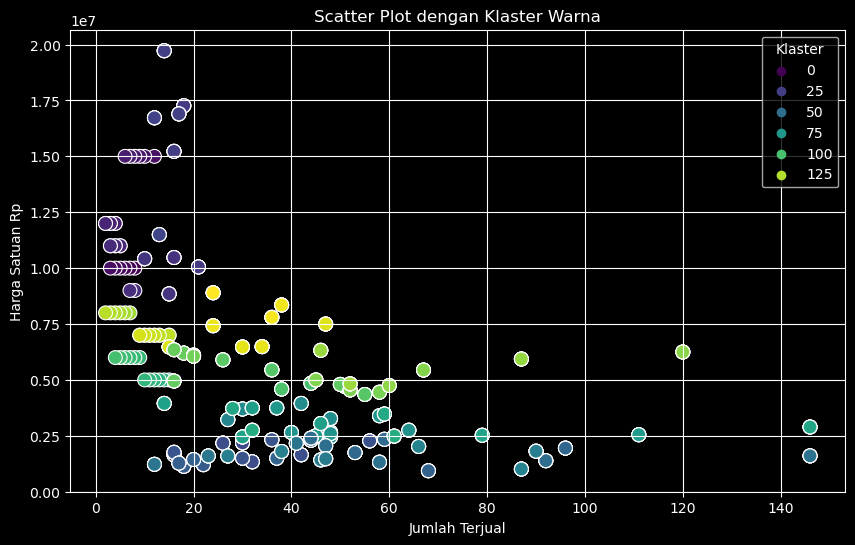

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot scatter plot dengan pemetaan warna berdasarkan kluster
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Jumlah_Terjual', y='Harga_Satuan_Rp', hue='Cluster', data=df_klastering, palette='viridis', s=100)

# Memberikan judul dan label sumbu
plt.title('Scatter Plot dengan Klaster Warna')
plt.xlabel('Jumlah Terjual')
plt.ylabel('Harga Satuan Rp')

# Menampilkan legenda
plt.legend(title='Klaster')

# Menampilkan plot
plt.grid(True)
plt.show()


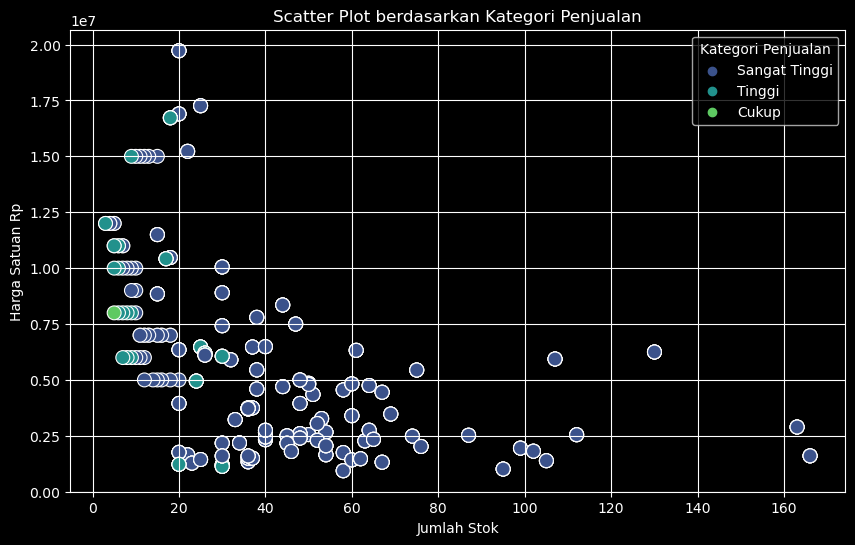

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot scatter plot dengan pemetaan warna berdasarkan kategori penjualan
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Jumlah_Stok', y='Harga_Satuan_Rp', hue='Kategori_Penjualan', data=df_klastering, palette='viridis', s=100)

# Memberikan judul dan label sumbu
plt.title('Scatter Plot berdasarkan Kategori Penjualan')
plt.xlabel('Jumlah Stok')
plt.ylabel('Harga Satuan Rp')

# Menampilkan legenda
plt.legend(title='Kategori Penjualan')

# Menampilkan plot
plt.grid(True)
plt.show()


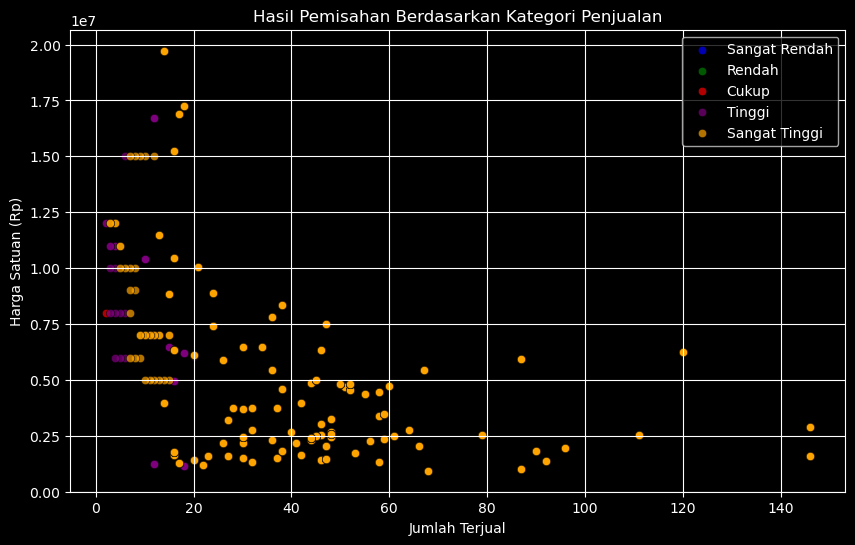

In [67]:
import matplotlib.pyplot as plt

# Visualisasi hasil pemisahan berdasarkan kategori penjualan
plt.figure(figsize=(10, 6))

# Definisi warna untuk setiap kategori penjualan
colors = {
    'Sangat Rendah': 'blue',
    'Rendah': 'green',
    'Cukup': 'red',
    'Tinggi': 'purple',
    'Sangat Tinggi': 'orange'
}

# Plot setiap kategori penjualan
for category, color in colors.items():
    plt.scatter(df_klastering.loc[df_klastering['Kategori_Penjualan'] == category, 'Jumlah_Terjual'],
                df_klastering.loc[df_klastering['Kategori_Penjualan'] == category, 'Harga_Satuan_Rp'],
                color=color, label=category, alpha=0.7, edgecolors='k', linewidths=0.5)

plt.title('Hasil Pemisahan Berdasarkan Kategori Penjualan')
plt.xlabel('Jumlah Terjual')
plt.ylabel('Harga Satuan (Rp)')
plt.legend()
plt.grid(True)
plt.show()


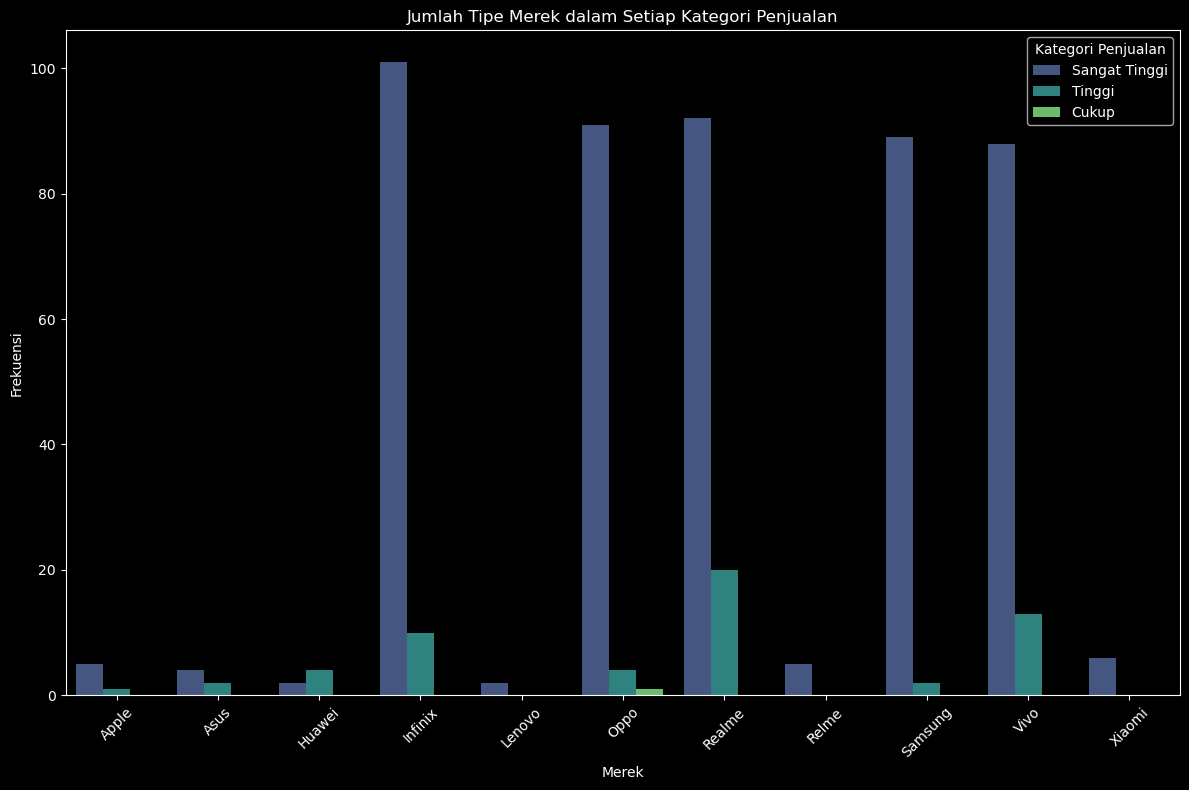

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definisikan urutan bulan yang benar
order_of_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']

# Pastikan kolom 'Bulan' di DataFrame adalah tipe kategori dengan urutan yang benar
df['Bulan'] = pd.Categorical(df['Bulan'], categories=order_of_months, ordered=True)

# Menghitung persentase jumlah terjual dibandingkan dengan jumlah stok
df['Persentase_Jumlah_Terjual'] = (df['Jumlah_Terjual'] / df['Jumlah_Stok']) * 100

# Menambahkan kolom kategori penjualan berdasarkan persentase
df['Kategori_Penjualan'] = df['Persentase_Jumlah_Terjual'].apply(categorize_sales_percentage)

# Menghitung jumlah tipe merek dalam setiap kategori penjualan
penjualan_merek = df.groupby(['Merek', 'Kategori_Penjualan']).size().reset_index(name='Frekuensi')

# Visualisasi dengan bar plot menggunakan seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='Merek', y='Frekuensi', hue='Kategori_Penjualan', data=penjualan_merek, palette='viridis')
plt.title('Jumlah Tipe Merek dalam Setiap Kategori Penjualan')
plt.xlabel('Merek')
plt.ylabel('Frekuensi')
plt.xticks(rotation=45)
plt.legend(title='Kategori Penjualan', loc='upper right')
plt.tight_layout()
plt.show()


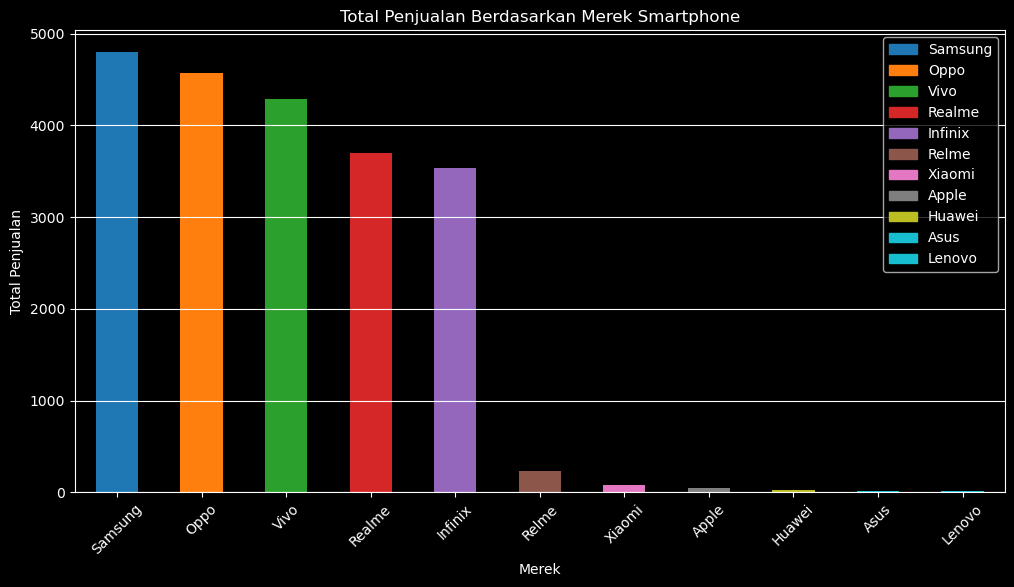

In [75]:
import matplotlib.pyplot as plt
import numpy as np

# Menghitung jumlah penjualan setiap merek
penjualan_merek = df.groupby('Merek')['Jumlah_Terjual'].sum().sort_values(ascending=False)

# Menghasilkan warna yang berbeda untuk setiap merek
colors = plt.cm.tab10(np.arange(len(penjualan_merek)))

# Membuat diagram batang dengan warna yang berbeda
plt.figure(figsize=(12, 6))
penjualan_merek.plot(kind='bar', color=colors)
plt.title('Total Penjualan Berdasarkan Merek Smartphone')
plt.xlabel('Merek')
plt.ylabel('Total Penjualan')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Menampilkan legenda untuk warna setiap merek
patches = [plt.Rectangle((0,0),1,1, color=colors[i], label=merek) for i, merek in enumerate(penjualan_merek.index)]
plt.legend(handles=patches, loc='upper right')

plt.show()


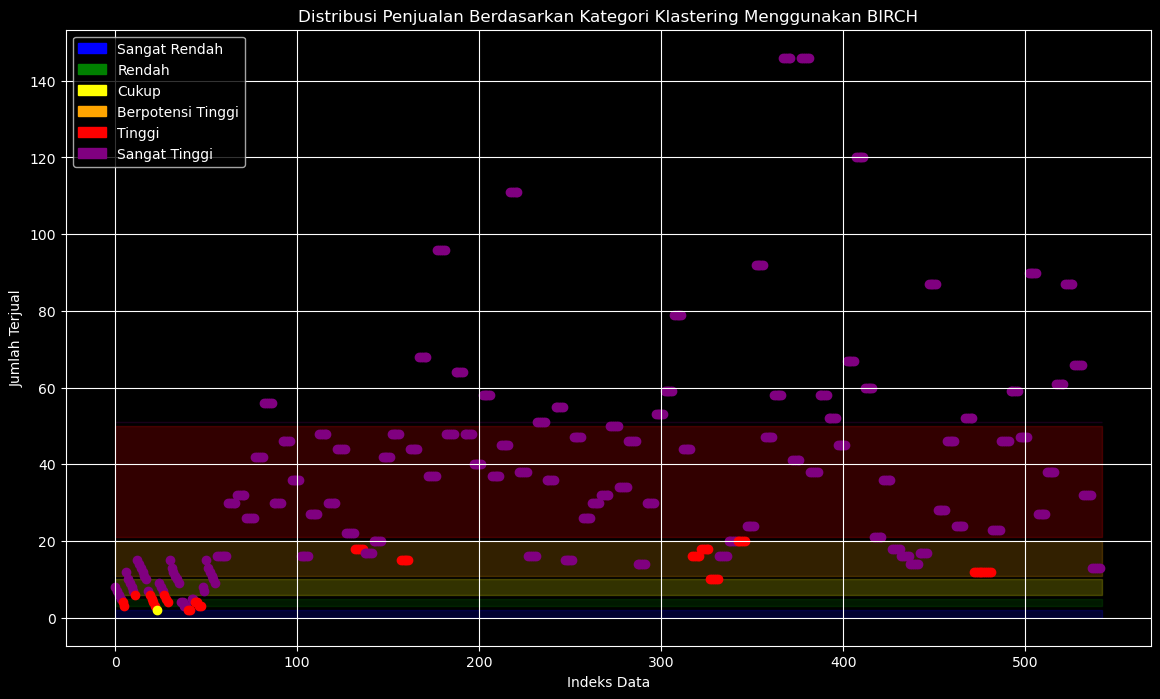

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Definisi batasan untuk setiap kelas
class_boundaries = {
    'Sangat Rendah': (0, 2),
    'Rendah': (3, 5),
    'Cukup': (6, 10),
    'Berpotensi Tinggi': (11, 20),
    'Tinggi': (21, 50),
    'Sangat Tinggi': (51, np.inf)
}

# Warna untuk setiap kategori penjualan
class_colors = {
    'Sangat Rendah': 'blue',
    'Rendah': 'green',
    'Cukup': 'yellow',
    'Berpotensi Tinggi': 'orange',
    'Tinggi': 'red',
    'Sangat Tinggi': 'purple'
}

# Visualisasi hasil klastering berdasarkan kategori penjualan
plt.figure(figsize=(14, 8))

# Plot area arsiran untuk setiap kelas
for class_name, (lower, upper) in class_boundaries.items():
    plt.fill_betweenx(y=[lower, upper], x1=0, x2=len(df), color=class_colors[class_name], alpha=0.2, label=f'{class_name}')

# Plot data penjualan berdasarkan kategori penjualan
for idx, row in df.iterrows():
    plt.scatter(idx, row['Jumlah_Terjual'], color=class_colors[row['Kategori_Penjualan']], label=row['Kategori_Penjualan'])

plt.title('Distribusi Penjualan Berdasarkan Kategori Klastering Menggunakan BIRCH')
plt.xlabel('Indeks Data')
plt.ylabel('Jumlah Terjual')
plt.grid(True)

# Menambahkan legend untuk keterangan warna berdasarkan kategori penjualan
handles = [plt.Rectangle((0,0),1,1, color=class_colors[label]) for label in class_boundaries.keys()]
labels = class_boundaries.keys()
plt.legend(handles, labels, loc='upper left')

# Fungsi untuk menampilkan merek dan tipe saat scatter plot diklik
def on_click(event):
    if event.xdata is not None and event.ydata is not None:
        idx = int(event.xdata)
        plt.gca().set_title('')
        plt.gca().annotate(f'Merek: {df.iloc[idx]["Merek"]}, Tipe: {df.iloc[idx]["Tipe"]}', xy=(event.xdata, event.ydata), xytext=(event.xdata + 10, event.ydata + 5), bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5), arrowprops=dict(arrowstyle="->", lw=0.5))

plt.gcf().canvas.mpl_connect('button_press_event', on_click)
plt.show()


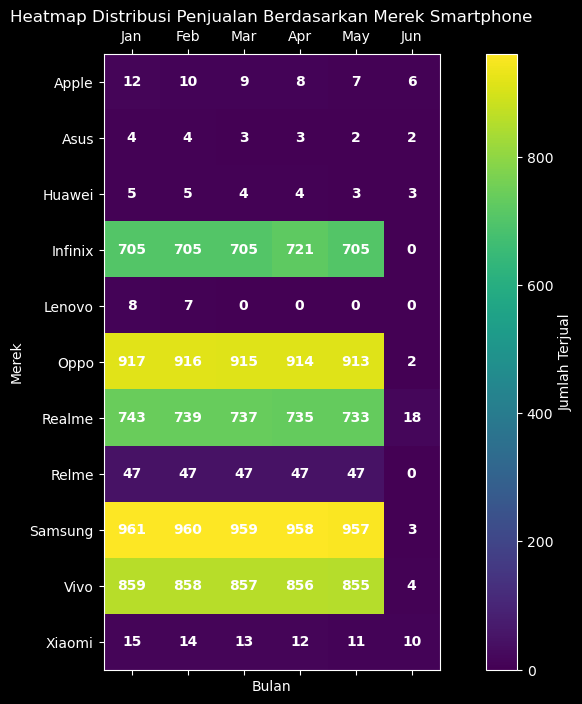

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

# Definisikan urutan bulan yang benar
order_of_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']

# Pastikan kolom 'Bulan' di DataFrame adalah tipe kategori dengan urutan yang benar
df['Bulan'] = pd.Categorical(df['Bulan'], categories=order_of_months, ordered=True)

# Menghitung jumlah penjualan setiap merek per bulan
penjualan_bulanan = df.pivot_table(
    index='Merek',
    columns='Bulan',
    values='Jumlah_Terjual',
    aggfunc='sum',
    fill_value=0
)

# Menggunakan heatmap dengan pandas visualization
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12, 8))

cax = ax.matshow(penjualan_bulanan, cmap='viridis')

# Menambahkan anotasi
for (i, j), val in np.ndenumerate(penjualan_bulanan.values):
    ax.text(j, i, f'{val}', ha='center', va='center', color='white', fontsize=10, fontweight='bold')

# Mengatur label axis
ax.set_xticks(range(len(penjualan_bulanan.columns)))
ax.set_yticks(range(len(penjualan_bulanan.index)))
ax.set_xticklabels(penjualan_bulanan.columns, color='white')
ax.set_yticklabels(penjualan_bulanan.index, color='white')

# Menambahkan color bar
fig.colorbar(cax, ax=ax, label='Jumlah Terjual')

plt.title('Heatmap Distribusi Penjualan Berdasarkan Merek Smartphone', color='white')
plt.xlabel('Bulan', color='white')
plt.ylabel('Merek', color='white')
plt.show()


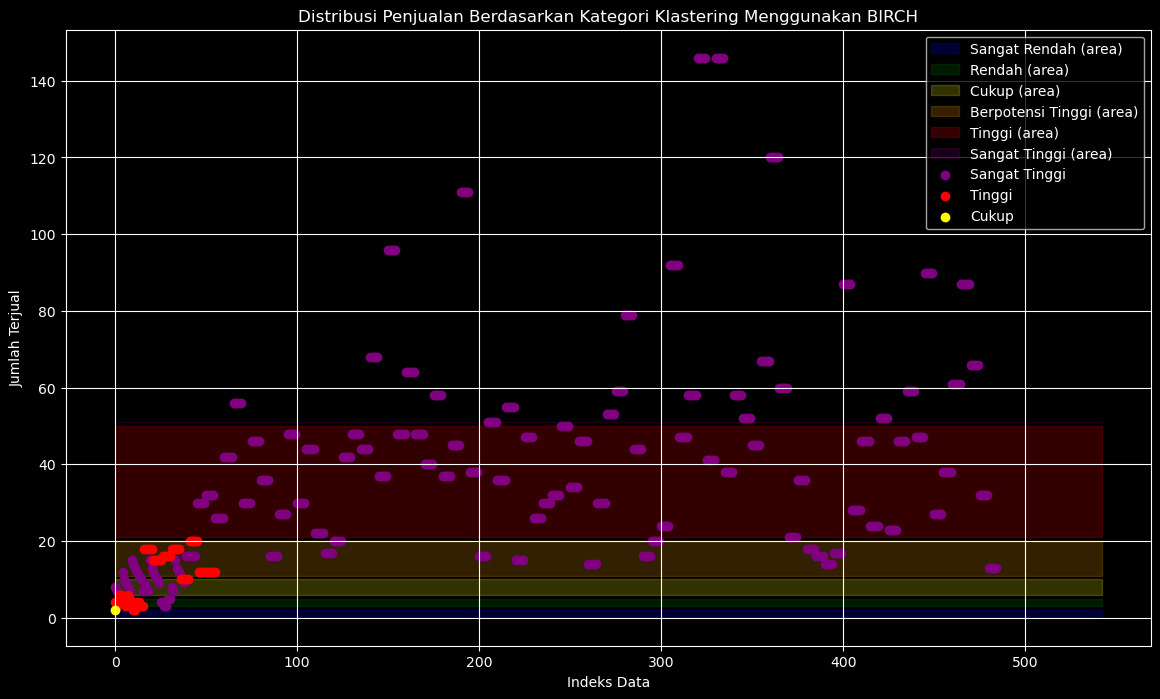

In [78]:

# Definisikan batasan untuk setiap kelas
class_boundaries = {
    'Sangat Rendah': (0, 2),
    'Rendah': (3, 5),
    'Cukup': (6, 10),
    'Berpotensi Tinggi': (11, 20),
    'Tinggi': (21, 50),
    'Sangat Tinggi': (51, np.inf)
}

# Warna untuk setiap kelas
class_colors = {
    'Sangat Rendah': 'blue',
    'Rendah': 'green',
    'Cukup': 'yellow',
    'Berpotensi Tinggi': 'orange',
    'Tinggi': 'red',
    'Sangat Tinggi': 'purple'
}

# Visualisasi hasil klastering berdasarkan kategori penjualan
plt.figure(figsize=(14, 8))

# Plot area arsiran untuk setiap kelas
for class_name, (lower, upper) in class_boundaries.items():
    plt.fill_betweenx(y=[lower, upper], x1=0, x2=len(df), color=class_colors[class_name], alpha=0.2, label=f'{class_name} (area)')

# Plot data penjualan
for class_name in df['Kategori_Penjualan'].unique():
    subset = df[df['Kategori_Penjualan'] == class_name]
    plt.scatter(range(len(subset)), subset['Jumlah_Terjual'], label=class_name, color=class_colors[class_name])

plt.title('Distribusi Penjualan Berdasarkan Kategori Klastering Menggunakan BIRCH')
plt.xlabel('Indeks Data')
plt.ylabel('Jumlah Terjual')
plt.legend()
plt.grid(True)
plt.show()


AttributeError: 'numpy.int32' object has no attribute 'startswith'

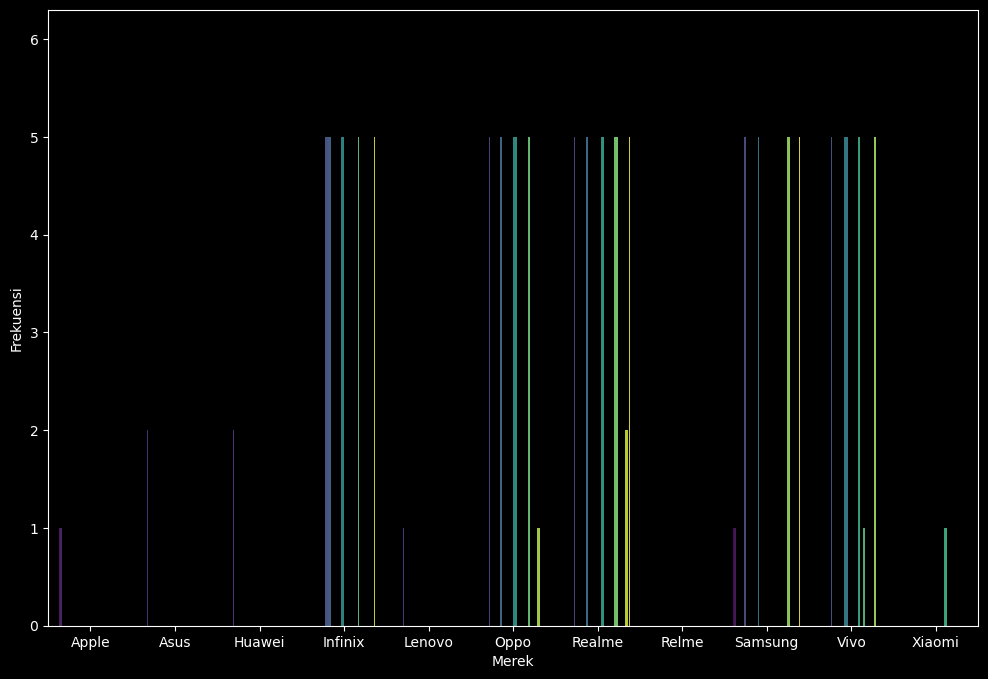

In [81]:
from sklearn.cluster import Birch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, IntSlider

# Contoh data dan proses sebelumnya
# Menghitung persentase jumlah terjual dibandingkan dengan jumlah stok
df_klastering['Persentase_Jumlah_Terjual'] = (df_klastering['Jumlah_Terjual'] / df_klastering['Jumlah_Stok']) * 100

# Definisi kategori berdasarkan persentase penjualan
def categorize_sales_percentage(percent_sold):
    if percent_sold < 10:
        return 'Sangat Rendah'
    elif percent_sold < 20:
        return 'Rendah'
    elif percent_sold < 50:
        return 'Cukup'
    elif percent_sold < 70:
        return 'Tinggi'
    else:
        return 'Sangat Tinggi'

# Menambahkan kolom kategori penjualan berdasarkan persentase
df_klastering['Kategori_Penjualan'] = df_klastering['Persentase_Jumlah_Terjual'].apply(categorize_sales_percentage)

# Inisialisasi nilai awal dan akhir threshold serta jumlah iterasi
threshold_start = 0.1
threshold_end = 0.5
num_iterations = 5

# Hitung increment threshold pada setiap iterasi
threshold_increment = (threshold_end - threshold_start) / (num_iterations - 1)

# Fungsi untuk melakukan klasterisasi dengan nilai threshold tertentu
def cluster_with_threshold(threshold):
    # Inisialisasi model BIRCH dengan nilai threshold
    birch_model = Birch(n_clusters=None, threshold=threshold)
    
    # Fit model BIRCH ke data dengan beberapa fitur (Jumlah_Stok, Harga_Satuan_Rp, Persentase_Jumlah_Terjual)
    df_features = df_klastering[['Jumlah_Stok', 'Harga_Satuan_Rp', 'Persentase_Jumlah_Terjual']]
    birch_model.fit(df_features)
    
    # Prediksi klaster
    clusters = birch_model.predict(df_features)
    
    # Menambahkan kolom klaster ke DataFrame
    df_klastering['Cluster'] = clusters
    
    # Menghitung jumlah tipe merek dalam setiap klaster
    penjualan_merek = df_klastering.groupby(['Merek', 'Cluster']).size().reset_index(name='Frekuensi')
    
    # Visualisasi dengan bar plot menggunakan seaborn
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Merek', y='Frekuensi', hue='Cluster', data=penjualan_merek, palette='viridis')
    plt.title(f'Jumlah Tipe Merek dalam Setiap Klaster (Threshold={threshold:.2f})')
    plt.xlabel('Merek')
    plt.ylabel('Frekuensi')
    plt.xticks(rotation=45)
    plt.legend(title='Cluster', loc='upper right')
    plt.tight_layout()
    plt.show()

# Iterasi untuk menguji berbagai nilai threshold secara bertahap
current_threshold = threshold_start
for i in range(num_iterations):
    cluster_with_threshold(current_threshold)
    current_threshold += threshold_increment
